# Kaggle Competition: Digit Recognizer 

[Digit Recognizer Competition](https://www.kaggle.com/c/digit-recognizer)

> MNIST ("Modified National Institute of Standards and Technology") is the de facto “hello world” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for > benchmarking classification algorithms. As new machine learning techniques emerge, MNIST remains a reliable resource for researchers and learners alike.

> In this competition, your goal is to correctly identify digits from a dataset of tens of thousands of handwritten images. We’ve curated a set of tutorial-style kernels which cover everything from regression to neural networks. We encourage you to experiment with different algorithms to learn first-hand what works well and how techniques compare.

## 1. Dependencies

In [1]:
import pandas as pd
import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import seaborn as sb
sb.set(style='white', context='notebook', palette='deep')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import itertools

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import Adadelta, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

/home/glauco/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## 2. Data Preparation

### 2.1. Download Data

Download the train and test datasets using Kaggle API:

```sh
$ kaggle competitions download digit-recognizer 
```

### 2.2. Load Data

In [2]:
train_dataframe = pd.read_csv('train.csv', sep=',')
test_dataframe = pd.read_csv('test.csv', sep=',')

# pandas.Dataframe.values returns a Numpy representation of the DataFrame.
train_data = train_dataframe.values
test_data = test_dataframe.values

### 2.3. Split Train, Validation and Test Sets

In [3]:
# Splits train and validation sets
X_train, y_train = train_data[:, 1:], train_data[:, 0]
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [4]:
X_test = test_data

### 2.4. Bonus: Free Some Memory

In [5]:
del train_dataframe, test_dataframe
del train_data, test_data

### 2.5. Visualize Categorical Classes Distribution

Before creating a model, we need to understand the classes distribution.

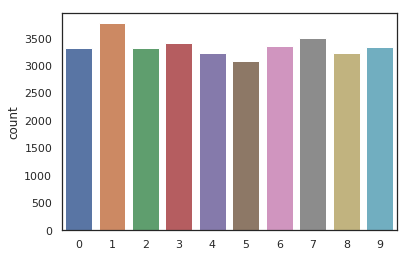

In [6]:
sb.countplot(y_train)

We see that there is a similar count for the 10 classes (digits between 0 and 9).

### 2.6. Normalize Data

We will apply zero-mean normalization to help gradient descent convergence.

In [7]:
# Ensures arrays are float32
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

In [8]:
# Ensures data have zero-mean
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

### 2.7. Reshape Data

Train and test images are 28px by 28px. Keras requires an extra dimenion in the end which corresponds to the channel. Since our images are grayscale, we just need to set it to 1.

In [9]:
img_rows, img_columns = 28, 28
input_shape = (img_rows, img_columns, 1)

# Reshapes training and validation data to a third-order degree
# Since MNIST is composed of grayscale images, just one channel is needed
X_train = X_train.reshape(X_train.shape[0], img_rows, img_columns, 1)
X_val = X_val.reshape(X_val.shape[0], img_rows, img_columns, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_columns, 1)

In [10]:
# Checks arrays dimensions
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)

(33600, 28, 28, 1)
(8400, 28, 28, 1)
(28000, 28, 28, 1)
(33600,)
(8400,)


### 2.8. Encode Labels

We convert our labels to one-hot encode to get multiclass classification using Softmax.

In [11]:
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)

### 2.9. Visualize Data

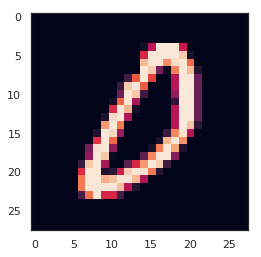

In [12]:
plt.imshow(X_train[42][:,:,0])

## 3. Model Creation

### 3.1. Model Hyperparameters

In [22]:
batch_size = 32
num_classes = 10
epochs = 5

### 3.2. Model 1: Single Convolution Layer

In [43]:
model1 = Sequential()

model1.add(Conv2D(32, kernel_size=(5,5), activation='relu', input_shape=input_shape))
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Flatten())
model1.add(Dense(32, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(num_classes, activation='softmax'))

model1.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

history = model1.fit(X_train, y_train,
                     batch_size=batch_size,
                     epochs=epochs,
                     validation_data=(X_val, y_val),
                     verbose=1)

Train on 33600 samples, validate on 8400 samples
Epoch 1/5
33600/33600 [==============================] - 14s 411us/step - loss: 0.6144 - acc: 0.7969 - val_loss: 0.1378 - val_acc: 0.9598
Epoch 2/5
33600/33600 [==============================] - 14s 405us/step - loss: 0.3178 - acc: 0.8989 - val_loss: 0.0969 - val_acc: 0.9711
Epoch 3/5
33600/33600 [==============================] - 14s 407us/step - loss: 0.2600 - acc: 0.9196 - val_loss: 0.0792 - val_acc: 0.9773
Epoch 4/5
33600/33600 [==============================] - 14s 417us/step - loss: 0.2261 - acc: 0.9267 - val_loss: 0.0706 - val_acc: 0.9782
Epoch 5/5
33600/33600 [==============================] - 15s 441us/step - loss: 0.2092 - acc: 0.9321 - val_loss: 0.0661 - val_acc: 0.9808


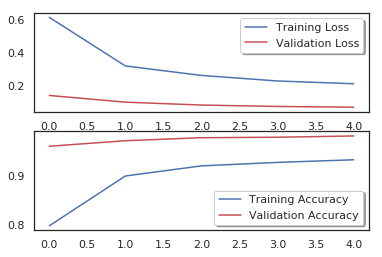

In [47]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(history.history['loss'], color='b', label='Training Loss')
ax[0].plot(history.history['val_loss'], color='r', label='Validation Loss', axes=ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label='Training Accuracy')
ax[1].plot(history.history['val_acc'], color='r', label='Validation Accuracy')
legend = ax[1].legend(loc='best', shadow=True)

### 3.3. Model 2: Two Convolution Layers

In [48]:
model2 = Sequential()

model2.add(Conv2D(32, kernel_size=(5,5), activation='relu', input_shape=input_shape))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Conv2D(64, kernel_size=(5,5), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Flatten())
model2.add(Dense(32, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(num_classes, activation='softmax'))

model2.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

history = model2.fit(X_train, y_train,
                     batch_size=batch_size,
                     epochs=epochs,
                     validation_data=(X_val, y_val),
                     verbose=1)

Train on 33600 samples, validate on 8400 samples
Epoch 1/5
33600/33600 [==============================] - 32s 957us/step - loss: 0.4685 - acc: 0.8441 - val_loss: 0.0921 - val_acc: 0.9736
Epoch 2/5
33600/33600 [==============================] - 34s 1ms/step - loss: 0.2183 - acc: 0.9274 - val_loss: 0.0632 - val_acc: 0.9801
Epoch 3/5
33600/33600 [==============================] - 33s 991us/step - loss: 0.1692 - acc: 0.9422 - val_loss: 0.0592 - val_acc: 0.9812
Epoch 4/5
33600/33600 [==============================] - 34s 1ms/step - loss: 0.1465 - acc: 0.9493 - val_loss: 0.0484 - val_acc: 0.9864
Epoch 5/5
33600/33600 [==============================] - 34s 1ms/step - loss: 0.1335 - acc: 0.9534 - val_loss: 0.0435 - val_acc: 0.9877


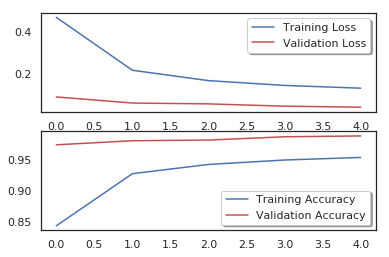

In [50]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(history.history['loss'], color='b', label='Training Loss')
ax[0].plot(history.history['val_loss'], color='r', label='Validation Loss', axes=ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label='Training Accuracy')
ax[1].plot(history.history['val_acc'], color='r', label='Validation Accuracy')
legend = ax[1].legend(loc='best', shadow=True)

### 3.4. Model 3: Four Convolution Layers

In [51]:
model3 = Sequential()

model3.add(Conv2D(32, kernel_size=(5,5), activation='relu', input_shape=input_shape))
model3.add(Conv2D(32, kernel_size=(5,5), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2,2)))

model3.add(Conv2D(64, kernel_size=(5,5), activation='relu'))
model3.add(Conv2D(64, kernel_size=(5,5), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2,2)))

model3.add(Flatten())
model3.add(Dense(32, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(num_classes, activation='softmax'))

model3.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

history = model3.fit(X_train, y_train,
                     batch_size=batch_size,
                     epochs=epochs,
                     validation_data=(X_val, y_val),
                     verbose=1)

Train on 33600 samples, validate on 8400 samples
Epoch 1/5
33600/33600 [==============================] - 98s 3ms/step - loss: 0.4296 - acc: 0.8607 - val_loss: 0.0697 - val_acc: 0.9800
Epoch 2/5
33600/33600 [==============================] - 99s 3ms/step - loss: 0.1683 - acc: 0.9502 - val_loss: 0.0505 - val_acc: 0.9861
Epoch 3/5
33600/33600 [==============================] - 99s 3ms/step - loss: 0.1333 - acc: 0.9610 - val_loss: 0.0467 - val_acc: 0.9871
Epoch 4/5
33600/33600 [==============================] - 101s 3ms/step - loss: 0.1047 - acc: 0.9671 - val_loss: 0.0541 - val_acc: 0.9875
Epoch 5/5
33600/33600 [==============================] - 99s 3ms/step - loss: 0.0978 - acc: 0.9707 - val_loss: 0.0453 - val_acc: 0.9887


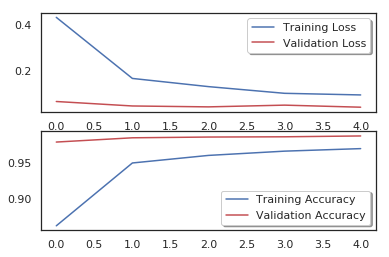

In [53]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(history.history['loss'], color='b', label='Training Loss')
ax[0].plot(history.history['val_loss'], color='r', label='Validation Loss', axes=ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label='Training Accuracy')
ax[1].plot(history.history['val_acc'], color='r', label='Validation Accuracy')
legend = ax[1].legend(loc='best', shadow=True)

### 3.5. Model 4: Adds Multiple Fully Connected Layers

In [65]:
model4 = Sequential()

model4.add(Conv2D(32, kernel_size=(5,5), activation='relu', input_shape=input_shape))
model4.add(MaxPooling2D(pool_size=(2,2)))

model4.add(Conv2D(64, kernel_size=(5,5), activation='relu'))
model4.add(MaxPooling2D(pool_size=(2,2)))

model4.add(Flatten())

model4.add(Dense(1024, activation='relu'))
model4.add(Dropout(rate=0.25))

model4.add(Dense(1024, activation='relu'))
model4.add(Dropout(rate=0.5))

model4.add(Dense(num_classes, activation='softmax'))

model4.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

datagen = ImageDataGenerator(featurewise_center=False,
                             samplewise_center=False,
                             featurewise_std_normalization=False,
                             samplewise_std_normalization=False,
                             zca_whitening=False,
                             rotation_range=10,
                             zoom_range=0.1,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=False,
                             vertical_flip=False)

datagen.fit(X_train)

history = model4.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                               epochs=30,
                               steps_per_epoch=X_train.shape[0] // batch_size,
                               validation_data=(X_val, y_val),
                               verbose=1)

Epoch 1/30
1050/1050 [==============================] - 66s 63ms/step - loss: 0.3257 - acc: 0.8935 - val_loss: 0.0556 - val_acc: 0.9819
Epoch 2/30
1050/1050 [==============================] - 67s 64ms/step - loss: 0.0926 - acc: 0.9724 - val_loss: 0.0304 - val_acc: 0.9895
Epoch 3/30
1050/1050 [==============================] - 68s 64ms/step - loss: 0.0706 - acc: 0.9794 - val_loss: 0.0292 - val_acc: 0.9900
Epoch 4/30
1050/1050 [==============================] - 67s 64ms/step - loss: 0.0608 - acc: 0.9822 - val_loss: 0.0326 - val_acc: 0.9911
Epoch 5/30
1050/1050 [==============================] - 68s 65ms/step - loss: 0.0552 - acc: 0.9839 - val_loss: 0.0337 - val_acc: 0.9900
Epoch 6/30
1050/1050 [==============================] - 68s 64ms/step - loss: 0.0483 - acc: 0.9858 - val_loss: 0.0260 - val_acc: 0.9918
Epoch 7/30
1050/1050 [==============================] - 67s 64ms/step - loss: 0.0479 - acc: 0.9859 - val_loss: 0.0258 - val_acc: 0.9919
Epoch 8/30
1050/1050 [==========================

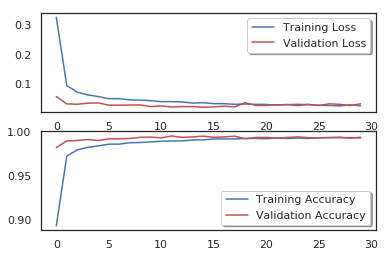

In [66]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(history.history['loss'], color='b', label='Training Loss')
ax[0].plot(history.history['val_loss'], color='r', label='Validation Loss', axes=ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label='Training Accuracy')
ax[1].plot(history.history['val_acc'], color='r', label='Validation Accuracy')
legend = ax[1].legend(loc='best', shadow=True)

## 4. Evaluate model drawbacks

In [73]:
def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    threshold = cm.max() / 2
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment='center',
                 color='white' if cm[i, j] > threshold else 'black')
        
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

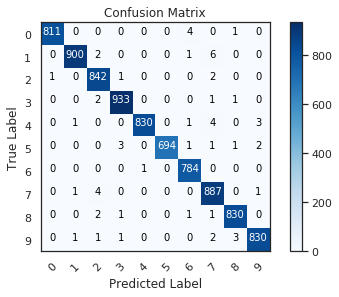

In [74]:
predictions = model4.predict(X_val)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_val, axis=1)

conf_matrix = confusion_matrix(true_classes, predicted_classes)

plot_confusion_matrix(conf_matrix, classes=range(10))

## 5. Evaluates model on test set

In [68]:
predictions = model4.predict(X_test)

In [69]:
labels = [np.argmax(predictions[i]) for i in range(predictions.shape[0])]
image_ids = range(1, len(labels) + 1)

## 6. Saves submission

In [70]:
df = pd.DataFrame({'ImageId': image_ids, 'Label': labels})

In [71]:
df.to_csv('submission.csv', encoding='utf-8', index=False)

Submit the results using Kaggle API:

```
$ kaggle competitions submit -f submission.csv -m 'Recognizing digits with Keras and Tensorflow' digit-recognizer
```